<h2>About this Project</h2>

<p>In this project, you will implement a simple multilayer perceptron for a regression problem.</p>

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
    
<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

<h2>Getting Started</h2>
<h3>Python Initialization</h3> 

Please run the following code to initialize your Python kernel. You should be running a version of Python 3.x. </p>

In [51]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%autoreload 2
import numpy as np
from numpy.matlib import repmat
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

from helper import *

%matplotlib inline
print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.6.8


<h3>Visualizing Data</h3>
<p>In the cell below, you generate a simple 1-dimensional toy dataset by calling <code>generate_data</code>. This function returns the data $\mathbf{X}$ and label $\mathbf{y}$. Note that $\mathbf{X}$ is of shape (N, 2). We append 1 to each example to introduce bias.</p>

In [53]:
X, y = generate_data()

print(f'The shape of X is {X.shape}. This is because we append 1 to each feature vector to introduce bias!')

The shape of X is (50, 2). This is because we append 1 to each feature vector to introduce bias!


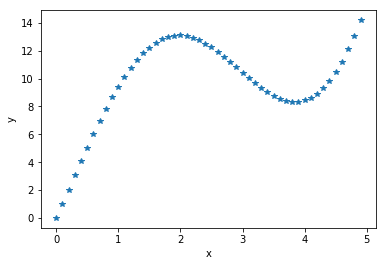

In [54]:
plt.plot(X[:, 0], y, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<h2>Multilayer Perceptron</h2>

<h3>Part Zero: Transition Function and Transition Function's gradient</h3>
<p>Transition functions are the key component of a neural network that contributes to its nonlinearity. For our neural network, we are going to use the ReLU transition function. Recall that the ReLU transition is as follows:</p>
$$\sigma(z) = \max(z, 0)$$

<p>We have implemented the <code>ReLU</code> and <code>ReLU_grad</code> functions as follow: (As its name suggests,  <code>ReLU_grad</code> computes the gradient of the ReLU function.)</p>

In [55]:
def ReLU(z):
    return np.maximum(z, 0)

In [56]:
def ReLU_grad(z):
    return (z > 0).astype('float64')

<h4>Visualize the Activation Function</h4>
We can now visualize the activation function in the plot above by running the code in the cell below.

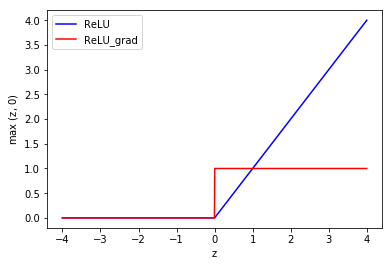

In [57]:
plt.plot(np.linspace(-4, 4, 1000), ReLU(np.linspace(-4, 4, 1000)),'b-')
plt.plot(np.linspace(-4, 4, 1000), ReLU_grad(np.linspace(-4, 4, 1000)),'r-')
plt.xlabel('z')
plt.ylabel(r'$\max$ (z, 0)')
plt.legend(['ReLU','ReLU_grad'])

We can also display the function and its gradient on a small example vector:

In [58]:
x=np.array([2.7,-0.5,-3.2])
print("X:",x)
print("ReLU(X):",ReLU(x))
print("ReLU_grad(X):",ReLU_grad(x))

X: [ 2.7 -0.5 -3.2]
ReLU(X): [2.7 0.  0. ]
ReLU_grad(X): [1. 0. 0.]


### Part One: Forward Pass [Graded]

In this section, you will implement the forward pass function **`forward_pass(W, xTr)`**. Note that $\mathbf{W}$ specifies the weights of the network at each layer. More specifically, $\mathbf{W}[0]$ stores the weights for the first layer of the network, $\mathbf{W}[l]$ stores the weights of the $(l + 1)^{th}$ layer and $\mathbf{W}[L-1]$ stores the weights of the last layer.

Each layer of the network produces two outputs, $\mathbf{A}[l + 1]$ and $\mathbf{Z}[l + 1]$, where 
- $\mathbf{A}[l + 1] = \mathbf{Z}[l] * \mathbf{W}[l]$ for $l = 0, 1, 2, \dots, L-1$ and 
- $\mathbf{Z}[l + 1] = \sigma(\mathbf{A}[l+1])$ for $l = 0, 1, 2, \dots, L-2$ and 
- $\mathbf{Z}[L] = \mathbf{A}[L]$ for the output

Here, $*$ is matrix-multiplication and $\mathbf{Z}[0], \mathbf{A}[0]$ are both initialized to be the the training set.

For simplicity, we did not include bias when calculating $\mathbf{A}[l + 1]$. For the purpose of this assignment, this is fine since we have appended one in all the raw features and  our dataset is rather simple. In general, bias should always be included when calculating $\mathbf{A}[l + 1]$

To visualize the variables $\mathbf{A}$, $\mathbf{Z}$, and $\mathbf{W}$ a bit better, consider the following hypothetical neural net layer:

<center><img src="nnlayer.png" width="50%"></center>

It is important to note that $\mathbf{W}$ is an *array of matrices*, as specified in the docstring for the provided method `initweights`. Since layer $i$ has 2 nodes and layer $i+1$ has 3, $\mathbf{W}[i]$ is a 2 by 3 matrix. Additionally, $\sigma$ is applied elementwise to the values in $\mathbf{A}[i+1]$, and is `ReLU` for this assignment. The final output at the end of the neural network should be $\mathbf{Z}[L]$.

The following function will allow you to randomly generate initial weights for the neural network:

In [59]:
def initweights(specs):
    """
    Given a specification of the neural network, output a random weight array.
    
    Input:
        specs: array of length m-1, where m = len(specs). specs[0] should be the
               dimension of the feature and spec[-1] should be the dimension of output
    
    Output:
        W: array of length m-1, each element is a matrix where W[i].shape == (specs[i], specs[i+1])
    """
    W = []
    for i in range(len(specs) - 1):
        W.append(np.random.randn(specs[i], specs[i+1]))
    return W

#### If we want to create a network that:
1. Takes in feature of dimension 2
2. Has 1 hidden layer with 3 hidden units
3. Outputs a scalar

Then we initialize the the weights the following way:

In [60]:
W = initweights([2, 3, 1])

In the cell below, implement the forward pass function <code>forward_pass(W, xTr)</code>. The below is the pseudocode from the READ module: 

<center><img src="fwdpass_text.png" width="50%"></center>

A forward pass is used to evaluate a neural network on an input. However, here, we want to do a forward pass also to train a neural network. That is, we will follow it with a backward pass. Therefore, unlike the pseudocode you read previously in the module, your code should output $\mathbf{A}$ (a **list** of the outputs at each layer after multiplying by the weights) and $\mathbf{Z}$ (a **list** of all outputs at each layer after passing the results of $\mathbf{A}$ through our transition function). To be precise, the outputs to your function should be $\mathbf{A} = [\mathbf{A}_0, \mathbf{A}_1, \dots, \mathbf{A}_{L}]$ and $\mathbf{Z} = [ \mathbf{Z}_0, \mathbf{Z}_1, \dots, \mathbf{Z}_{L}]$. We need these intermediate results because it is much more efficient to not recompute them when we need them during the backward pass.

Here's the modified pseudocode that you should implement:

<center><img src="fwdpass_mat.png" width="50%"></center>

In [61]:
def forward_pass(W, xTr):
    """
    Propagates the data matrix xTr forward in the network specified by the weight matrices in the array W
    
    Input:
        W: a list of L weight matrices, specifying the network
        xTr: nxd data matrix. Each row is an input vector
    
    OUTPUTS:
        A, Z
        A: a list of L+1 matrices, each of which is the result of matrix multiplication of previous layer's outputs and weights.
           The first matrix in the list is xTr.
        Z: a list of L+1 matrices, each of which is the result of transition functions on elements of A.
           The first matrix in the list is xTr.
    """
    
    # Initialize A and Z
    A = [xTr]
    Z = [xTr]

    # YOUR CODE HERE
    for l in range(0,len(W)):
        Al = np.dot(Z[l],W[l])
        if l < len(W)-1 :
            Zl = ReLU(Al)
        else :
            Zl = Al
        A.append(Al)
        Z.append(Zl)
    
    return A, Z

In [62]:
# # test cell please ignore
# X, _ = generate_data() # generate data
# W = initweights([2, 3, 1])
# # # print(X)
# # print(len(W))
# # print(len(X))
# y= range(len(W))
# for x in y :
#     print(x)


In [63]:
def forward_test1():
    X, _ = generate_data() # generate data
    W = initweights([2, 3, 1]) # generate random weights
    out = forward_pass(W, X) # run forward pass
    return len(out) == 2 # make sure that your function return a tuple

def forward_test2():
    X, _ = generate_data() # generate data
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X) # run forward pass
    return len(A) == 3 and len(Z) == 3 # Make sure that output produced match the length of the weight + 1

def forward_test3():
    X, _ = generate_data() # generate data
    n, d = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X) # run forward pass
    return (A[0].shape == (n, d) and
            Z[0].shape == (n, d) and
            A[1].shape == (n, 3) and 
            Z[1].shape == (n, 3)  and
            A[2].shape == (n, 1) and
            A[2].shape == (n, 1) ) # Make sure the layer produce the right shape output

def forward_test4():
    X = -1*np.ones((1, 2)) # generate a feature matrix of all negative ones
    W = [np.ones((2, 1))] # a single layer network with weights one
    A, Z = forward_pass(W, X) # run forward pass
    
    # check whether you do not apply the transition function to A[-1] 
    return np.linalg.norm(Z[-1] - X@W[0]) < 1e-7

def forward_test5():
    X, _ = generate_data() # generate data
    n, _ = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X) # run your forward pass
    A_grader, Z_grader = forward_pass_grader(W, X) # run our forward pass
    
    Adiff = 0
    Zdiff = 0
    
    # compute the difference between your solution and ours
    for i in range(1, 3):
        Adiff += np.linalg.norm(A[i] - A_grader[i])
        Zdiff += np.linalg.norm(Z[i] - Z_grader[i])
        
    return Adiff < 1e-7 and Zdiff < 1e-7

runtest(forward_test1, "forward_test1")
runtest(forward_test2, "forward_test2")
runtest(forward_test3, "forward_test3")
runtest(forward_test4, "forward_test4")
runtest(forward_test5, "forward_test5")

Running Test: forward_test1 ... ✔ Passed!
Running Test: forward_test2 ... ✔ Passed!
Running Test: forward_test3 ... ✔ Passed!
Running Test: forward_test4 ... ✔ Passed!
Running Test: forward_test5 ... ✔ Passed!


In [64]:
# Autograder Test Cell
# Forward_test1


In [65]:
# Autograder Test Cell
# Forward_test2


In [66]:
# Autograder Test Cell
# Forward_test3


In [67]:
# Autograder Test Cell
# Forward_test4


In [68]:
# Autograder Test Cell
# Forward_test5


### Part Two: MSE Loss and Gradient [Graded]
#### Loss Function [Graded]

In this section, you are going to implement the Mean Squared Error (MSE) loss function for regression. Recall that for a set of training example $\left\{ \left( \mathbf{x}_1, y_1 \right), \dots, \left(\mathbf{x}_n, y_n \right) \right\}$, the MSE of the network $h$ is 

$$
\mathcal{L} = \frac{1}{n} \sum_{i = 1}^n \left( h \left(\mathbf{x}_i \right) - y_i \right)^2
$$

The **`MSE`** function you are going to implement takes the output of the network `out` and the labels `y` and computes the MSE loss.

In [69]:
def MSE(out, y):
    """
    Calculates the Mean Squared Error for output and true labels y.

    Input:
        out: output of network (n-dimensional vector)
        y: true labels (n-dimensional vector)
    
    Output:
        loss: the MSE loss (a scalar)
    """
    
    n = len(y)
    loss = 0

    # YOUR CODE HERE
    temp = 0
    for i in range(0,n):
        t1 = out[i]-y[i]
        temp = temp+(t1**2)
    loss = temp/n
    return loss

In [70]:
def MSE_test1():
    X, y = generate_data() # generate data
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    loss = MSE(Z[-1].flatten(), y) # calculate loss
    
    return np.isscalar(loss) # your loss should be a scalar

def MSE_test2():
    X, y = generate_data() # generate data
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    loss = MSE(Z[-1].flatten(), y) # calculate loss
    
    return loss >= 0 # your loss should be nonnegative

def MSE_test3():
    X, y = generate_data() # generate data
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    loss = MSE(Z[-1].flatten(), y) # calculate loss
    loss_grader = MSE_grader(Z[-1].flatten(), y)
    
    # your loss should not deviate too much from ours
    # If you fail this test case, check whether you divide your loss by 1/n
    return np.absolute(loss - loss_grader) < 1e-7 

runtest(MSE_test1, "MSE_test1")
runtest(MSE_test2, "MSE_test2")
runtest(MSE_test3, "MSE_test3")

Running Test: MSE_test1 ... ✔ Passed!
Running Test: MSE_test2 ... ✔ Passed!
Running Test: MSE_test3 ... ✔ Passed!


In [71]:
# Autograder Test Cell
# MSE_test1


In [72]:
# Autograder Test Cell
# MSE_test2


In [73]:
# Autograder Test Cell
# MSE_test3


#### Gradient [Graded]

You will now need to implement the gradient of the MSE loss calculated above. When you take the derivative of the above with respect to the entries of `out`, you get the following:

$$
\nabla \mathcal{L} = \frac{2}{n} \cdot \left( h \left(\mathbf{x}_i \right) - y_i \right)
$$

Implement the above in the function **`MSE_grad`**.

In [74]:
def MSE_grad(out, y):
    """
    Calculates the gradient of the MSE loss w.r.t. network output.
    
    Input:
        out: output of network (n-dimensional vector)
        y: true labels (n-dimensional vector)
    
    Output:
        grad: the gradient of the MSE loss with respect to out (n-dimensional vector)
    """
    
    n = len(y)
    grad = np.zeros(n)

    # YOUR CODE HERE
    for i in range(0,n) :
        temp = out[i]-y[i]
        grad[i] = (2*temp)/n
    return grad


In [75]:
def MSE_grad_test1():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    
    grad = MSE_grad(Z[-1].flatten(), y)
    return grad.shape == (n, ) # check if the gradient has the right shape

def MSE_grad_test2():
    out = np.array([1])
    y = np.array([1.2])
    
    # calculate numerical gradient using finite difference
    numerical_grad = (MSE(out + 1e-7, y) - MSE(out - 1e-7, y)) / 2e-7
    grad = MSE_grad(out, y)
    
    # check your gradient is close to the numerical gradient
    return np.linalg.norm(numerical_grad - grad) < 1e-7

def MSE_grad_test3():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    
    grad = MSE_grad(Z[-1].flatten(), y)
    grad_grader = MSE_grad_grader(Z[-1].flatten(), y) # compute gradient using our solution
    
    # your gradient should not deviate too much from ours
    return np.linalg.norm(grad_grader - grad) < 1e-7

runtest(MSE_grad_test1, 'MSE_grad_test1')
runtest(MSE_grad_test2, 'MSE_grad_test2')
runtest(MSE_grad_test3, 'MSE_grad_test3')

Running Test: MSE_grad_test1 ... ✔ Passed!
Running Test: MSE_grad_test2 ... ✔ Passed!
Running Test: MSE_grad_test3 ... ✔ Passed!


In [76]:
# Autograder Test Cell
# MSE_grad_test1


In [77]:
# Autograder Test Cell
# MSE_grad_test2


In [78]:
# Autograder Test Cell
# MSE_grad_test3


### Part Three: Backpropagation [Graded]

In this section, you are going to implement the **`backprop`** for a ReLU network specified by weights $\mathbf{W}$. To recap, this is the stage that updates all the weights in the network starting from the last layer. Again, our implementation will have slight tweaks from the pseudocode you read earlier. 

<center><img src="backpass_text.png" width="50%"></center>

The algorithm looks like this after modifying the notation:

<center><img src="backpass_mat.png" width="50%"></center>

**Implementation Notes:**
- We recommend the for-loop backwards, i.e., starting at the gradient for $\mathbf{W}[L-1]$, calculating the next "link", and repeating these 2 steps until you reach the gradient for $\mathbf{W}[0]$.
- Recall that in backpropagation, for each layer $l$, we alternate between calculating a "link" ( $\frac{\partial \mathcal{L}}{\partial \mathbf A_{l+1}}$) and updating the weight ($\mathbf{W}_l = \mathbf{W}_l - \alpha \frac{\partial \mathcal{L}}{\partial \mathbf{W}_l}$). In this function, you only calculate the gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{W}_l}$, **without applying it**. In other words, you store all the $\frac{\partial \mathcal{L}}{\partial \mathbf{W}_l}$ for all $0 \le l \le L-1$, and return them all in the list `gradients`.
- In our code the "link" is `delta` $= \delta_{l} = \frac{\partial \mathcal{L}}{\partial \mathbf{A}_{l}}$. The line initializing it has been done for you, so you only need to implement the links inside the for-loop using the algorithm above.
- In python you can multiply two matrices `D, B` element-wise with `D * B`. 
- Ensure that each element of the output `gradient` list is the gradient with respect to the corresponding weight matrix in `W`.

In [81]:
def backprop(W, A, Z, y):
    """
    Implements the back-propagation algorithm for the network specified by weights in W
    and intermediate values A, Z for the data propagated forward (corresponding labels y).
    
    Input:
        W: a list of L weight matrices
        A: a list of L+1 matrices, each of which is the result of matrix multiplication of previous layer's outputs and weights.
           The first matrix in the list is the data.
        Z: a list of L+1 matrices, each of which is the result of transition functions on elements of A.
           The first matrix in the list is the data.
        y: true labels (n-dimensional vector)
        
    Output:
        gradient: a list of L matrices, each of which is the gradient with respect to the corresponding entry of W
    """
    
    # Convert delta to a row vector to make things easier
    delta = (MSE_grad(Z[-1].flatten(), y) * 1).reshape(-1, 1)

    # compute gradient with backprop
    gradients = []
    
    # YOUR CODE HERE
    # implement for loop backwards
    for i in range(len(W)-1,-1,-1):
        grad = np.dot(Z[i].T,delta)
        gradients.append(grad)
        delta = ReLU_grad(A[i])*(np.dot(delta,W[i].T))
    
    #reversing the gradients array
    gradients = gradients[::-1]
    
    return gradients
    

In [82]:
# # test cell please ignore
# for i in range(3,-1,-1):
#     print(i)

3
2
1
0


In [84]:
def backprop_test1():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    
    gradient = backprop(W, A, Z, y) # backprop to calculate the gradient
    
    # You should return a list with the same len as W
    return len(gradient) == len(W)

def backprop_test2():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    W = initweights([2, 3, 1]) # generate random weights
    A, Z = forward_pass(W, X)
    
    gradient = backprop(W, A, Z, y) # backprop to calculate the gradient
    
    # gradient[i] should match the shape of W[i]
    return np.all([gradient[i].shape == W[i].shape for i in range(len(W))])

def backprop_test3():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    
    # Use a one layer network
    # This is essentially the least squares
    W = initweights([2, 1]) 
    
    A, Z = forward_pass(W, X)
    
    # backprop to calculate the gradient
    gradient = backprop(W, A, Z, y) 
    
    # calculate the least square gradient
    least_square_gradient = 2 *((X.T @ X) @ W[0] - X.T @ y.reshape(-1, 1)) / n
    
    # gradient[0] should be the least square gradient
    return np.linalg.norm(gradient[0] - least_square_gradient) < 1e-7

def backprop_test4():
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    
    # Use a one layer network
    # This is essentially the least squares
    W = initweights([2, 5, 5, 1]) 
    
    A, Z = forward_pass(W, X)
    
    # backprop to calculate the gradient
    gradient = backprop(W, A, Z, y) 
    
    # calculate the backprop gradient
    gradient_grader = backprop_grader(W, A, Z, y)
    
    # Check whether your gradient matches ours
    OK=[len(gradient_grader)==len(gradient)] # check if length matches
    for (g,gg) in zip(gradient_grader,gradient): # check if each component matches in shape and values
        OK.append(gg.shape==g.shape and (np.linalg.norm(g - gg) < 1e-7))
    return(all(OK))

def backprop_test5():
    # Here we reverse your gradient output and check that reverse with ours. It shouldn't match. 
    # If your reverse gradient matches our gradient, this means you outputted the gradient in reverse order.
    # This is a common mistake, as the loop is backwards. 
    X, y = generate_data() # generate data
    
    n, _ = X.shape
    
    # Use a one layer network
    # This is essentially the least squares
    W = initweights([2, 5, 5, 1]) 
    
    A, Z = forward_pass(W, X)
    
    # backprop to calculate the gradient
    gradient = backprop(W, A, Z, y) 
    
    # calculate the backprop gradient
    gradient_grader = backprop_grader(W, A, Z, y)

    gradient.reverse() # reverse the gradient. From now on it should NOT match
    # Check whether your gradient matches ours
    OK=[] # check if length matches
    for (g,gg) in zip(gradient_grader,gradient): # check if each component matches
        OK.append(gg.shape==g.shape and (np.linalg.norm(g - gg) < 1e-7))
    return(not all(OK)) 



runtest(backprop_test1, 'backprop_test1')
runtest(backprop_test2, 'backprop_test2')
runtest(backprop_test3, 'backprop_test3')
runtest(backprop_test4, 'backprop_test4')
runtest(backprop_test5, 'backprop_test5')

Running Test: backprop_test1 ... ✔ Passed!
Running Test: backprop_test2 ... ✔ Passed!
Running Test: backprop_test3 ... ✔ Passed!
Running Test: backprop_test4 ... ✔ Passed!
Running Test: backprop_test5 ... ✔ Passed!


In [85]:
# Autograder Test Cell
# backprop_test1


In [86]:
# Autograder Test Cell
# backprop_test2


In [87]:
# Autograder Test Cell
# backprop_test3


In [88]:
# Autograder Test Cell
# backprop_test4


In [89]:
# Autograder Test Cell
# backprop_test5


<h3> Part Four: Training with Gradient Descent</h3>

Run the cell below to train a ReLU Network for the task with Gradient Descent. Feel free to play around with the hyperparameters such learning rate, number of epochs, number of hidden layers, size of each hidden layers. 

Elapsed time: 12.71s


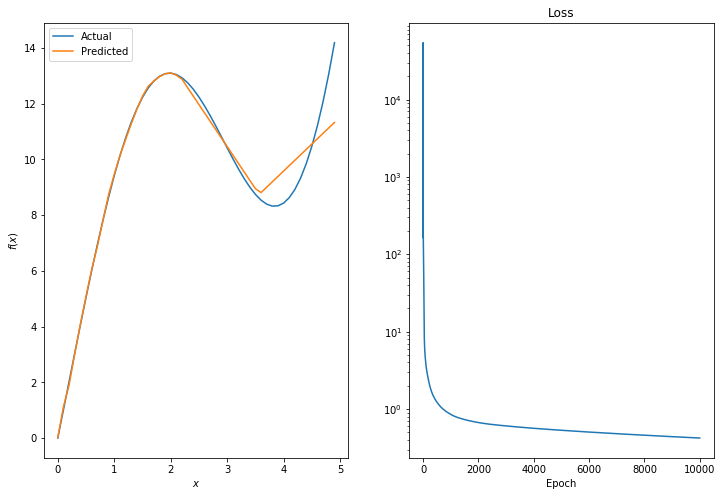

In [92]:
#generate data
X, y = generate_data() # generate data


# learning rate for Gradient Descent
lr = 0.001

# Number of epochs
# one epoch - one full pass through the dataset
M = 10000

# keep track of the losses
losses = np.zeros(M)
t0 = time.time()

# initialize a neural network with one hidden layer 
# Try varying the depth and width of the neural networks to see the effect

W = initweights([2, 200, 1])
W_init = [w.copy() for w in W]

# Start training
for i in range(M):
    
    # Do a forward pass
    A, Z = forward_pass(W, X)
    
    # Calculate the loss
    losses[i] = MSE(Z[-1].flatten(), y)
    
    # Calculate the loss using backprop
    gradients = backprop(W, A, Z, y)
    
    # Update he parameters
    for j in range(len(W)):
        W[j] -= lr * gradients[j]
t1 = time.time()
print('Elapsed time: %.2fs' % (t1-t0))
plot_results(X[:, 0], y, Z, losses)

## Tensorflow

[Tensorflow](https://www.tensorflow.org/) is a widely known Machine Learning library that provides classes and functions to create neural networks from scratch and train them using gradient descent (and its variants). The library also provides numerous [datasets](https://www.tensorflow.org/datasets), many of which are widely used in industry and academic research.
    
Most importantly, Tensorflow, and other Machine Learning libraries such as [Pytorch](https://pytorch.org/) and [MXNet](https://mxnet.apache.org/) , allow for "[automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)". With this feature, the developer only needs to specify the neural network architecture (e.g. kind of layers, number of hidden units, activation functions etc.); the library performs backpropagation automatically---it computes gradients for the trainable weights of the network and applies them during training. This feature is extremely useful when the network design becomes complex and it becomes difficult to write backprop functions by hand.

### Training a model with Tensorflow

In this section, we show you how to train a model with Tensorflow. The steps are similar to above:
1. Define the model structure, describing the layers for forward propagation.
2. Define the optimizer, i.e., the variant of gradient descent you want to use.
3. Define the loss function to minimize.
4. "Fit" the model on training data for $M$ epochs.

The "fitting" process propagates the data forward in the network, computes the loss value, computes the gradients for the weights, and updates the weights for $M$ times.

In [93]:
import tensorflow as tf
print('TF version: %s' % (tf.__version__))

# Tensorflow by default uses float32 and expects data in that format. Since our data matrices X and y are in np.float64 format, we specify float64 here.
tf.keras.backend.set_floatx('float64')

TF version: 2.6.2


In [94]:
# 1. Define the model structure
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=200, input_dim=2, activation='relu', use_bias=False, kernel_initializer='random_normal'),
    tf.keras.layers.Dense(units=1, activation=None, use_bias=False, kernel_initializer='random_normal'),
])

Let's break this down. Our network should comprise of 3 layers: [input, hidden, output]. 

- The input layer should have 2 dimensions to match the feature dimension of each of the 50 training points in $\mathbf{X}$.
- Using `Dense` with 200 units, we specify a fully-connected layer with 200 hidden units. This is equivalent to multiplying 2-dimensional input with $\mathbf{W}_0$ of shape $2 \times 200$. We also specify the `ReLU` activation function.
- Then we specify another `Dense` layer with 1 unit, which is equivalent to multiplying the 200-dimensional hidden layer vector with $\mathbf{W}_1$ of shape $200 \times 1$. Here we don't specify any activation function as the final $\mathbf{Z}_2$ is just $\mathbf{A}_2$.

To emulate the network in the exercise above, we initialize the weights of the Tensorflow network with random normal values. Since $\mathbf{X}$ already contains a bias value, we avoid bias terms in the network.

In [95]:
# 2. Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
training_batch_size = len(y)

Tensorflow does not provide vanilla gradient descent. Instead, the basic variant it provides is called [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). To match our implementation above, we can use SGD to behave like vanilla gradient descent by setting the `training_batch_size` to the number of data points.

What does this do? Although the loss is calculated using all data points, SGD computes the gradients of weights using `training_batch_size` number of data points. So, when the `training_batch_size` is smaller than the number of training data points, SGD _approximates_ the gradients of weights (this is done for various reasons, but we will not discuss it here). To compute exact gradients and match our implementation in the previous section, we just set the `training_batch_size` to number of training points `len(y)`. 

In [96]:
# 3. Define loss function
loss = tf.keras.losses.MeanSquaredError()

t0 = time.time()

# Attach the optimizer and loss function to the model
model.compile(optimizer=optimizer,loss=loss)

# 4. Fit the model on training data
history = model.fit(
    X,
    y,
    epochs=M,
    batch_size=training_batch_size,
    verbose=0, # no progress bar
)
t1 = time.time()
print('Elapsed time: %.2fs' % (t1-t0))

Elapsed time: 16.10s


It is possible that the Tensorflow model takes much longer to train that our initial implementation took. This is because of the massive overhead Tensorflow requires to setup and train the model. However, as the number of training points increases and the network becomes more complex, Tensorflow (and other Machine Learning libraries) scale much better than pure-Numpy implementations---even better when you use a GPU. For this reason, developers and researchers almost always use libraries like Tensorflow and Pytorch to train networks.

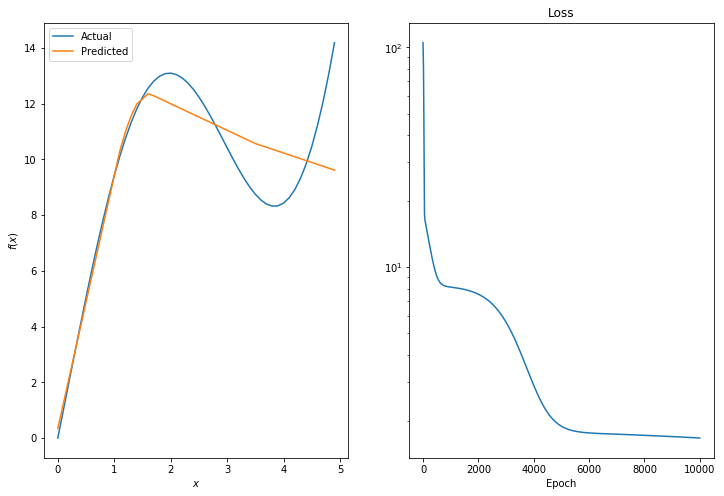

In [97]:
def tf_activations(model, X):
    """
    function tf_activations(model, X)
    
    INPUT:
    model - Tensorflow model
    X - nxd matrix. Each row is an input vector
    
    OUTPUTS:
    Z - a list of matrices (of length L) that stores result of transition function at each layer 
    """
    inputs = [model.input]
    outputs = [layer.output for layer in model.layers]             # all layer outputs
    get_activations = tf.keras.backend.function(inputs, outputs)   # evaluation function
    
    Z = [X] + get_activations([X])
    return Z

losses = history.history['loss']
Z = tf_activations(model, X)
plot_results(X[:, 0], y, Z, losses)

Don't worry if these plots don't match the ones above! The Numpy and Tensorflow implementations had different initial weights for the network. It is possible to obtain matching plots by specifying initial weights in Tensorflow; however, the approach is a little more involved and we will leave it to the curious reader.